In [1]:
import pickle
with open("../data/bad_node_label.pickle", 'rb') as f:
    label = pickle.load(f)

In [2]:
zipbObj = zip([label[i][0] for i in range(len(label))], [label[i][1] for i in range(len(label))])
label = dict(zipbObj)

In [21]:
!pip install --upgrade pandas

    100% |████████████████████████████████| 15.9MB 1.6MB/s ta 0:00:011
  Found existing installation: pandas 0.23.4
    Uninstalling pandas-0.23.4:
      Successfully uninstalled pandas-0.23.4


In [30]:
with open("../data/help.pickle", 'rb') as f:
    data = pickle.load(f)

In [32]:
a = data[0]

In [33]:
for i in range(1,len(data)):
    a.update(data[i])

In [8]:
key = [key for key in a]

In [225]:
import pandas as pd
bad = pd.DataFrame()
good = pd.DataFrame()
for k in range(30):
    good = pd.concat([good, a[key[k]].sort_values(0)])
    #import pdb; pdb.set_trace()
    if int(key[k]) < 0:
        bad_list = [i-1 for i in label[int(key[k])]]
        temp = a[key[k]].sort_values(0).iloc[bad_list,1:129]
        bad = pd.concat([bad, temp])
        if temp.shape[0] != 0:
            good = pd.concat([good, a[key[k]].sort_values(0).drop(bad_list)])


In [226]:
bad['label'] = 1

In [227]:
good['label'] = 0

In [228]:
good = good.drop(0,axis=1)

In [229]:
x = pd.concat([bad,good])

In [230]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x.iloc[:,0:128], x['label'], test_size = 0.2, random_state = 0)

In [231]:
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam

In [232]:
n_timesteps, n_features, n_outputs = x_train.shape[0], x_train.shape[1], y_train.shape[0]

In [233]:
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))

model.add(Dense(units=1, activation='sigmoid'))

In [234]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_44 (Dense)             (None, 20)                2580      
_________________________________________________________________
dense_45 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_46 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_47 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_48 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_49 (Dense)             (None, 20)                420       
__________

In [235]:
goo = sum(y_train==1)/x_train.shape[0]
baa = 1 - goo

In [236]:
x_train.shape[0]

178029

In [238]:
sum(y_train==1)

81

In [237]:
goo

0.0004549820534856681

In [239]:
class_weights = {0: sum(y_train==1),1:x_train.shape[0] -sum(y_train==1)}

In [241]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=512,class_weight=class_weights)

Epoch 1/20
178029/178029 [==============================] - 3s 18us/step - loss: 113.3220 - acc: 0.4335
Epoch 2/20
178029/178029 [==============================] - 2s 10us/step - loss: 109.4475 - acc: 0.4270
Epoch 3/20
178029/178029 [==============================] - 2s 10us/step - loss: 75.4243 - acc: 0.9148
Epoch 4/20
178029/178029 [==============================] - 2s 10us/step - loss: 51.5084 - acc: 0.9243
Epoch 5/20
178029/178029 [==============================] - 2s 10us/step - loss: 55.7346 - acc: 0.9349
Epoch 6/20
178029/178029 [==============================] - 2s 10us/step - loss: 44.5908 - acc: 0.9323
Epoch 7/20
178029/178029 [==============================] - 2s 11us/step - loss: 41.6289 - acc: 0.9435
Epoch 8/20
178029/178029 [==============================] - 2s 10us/step - loss: 42.2525 - acc: 0.9156
Epoch 9/20
178029/178029 [==============================] - 2s 11us/step - loss: 39.4841 - acc: 0.9168
Epoch 10/20
178029/178029 [==============================] - 2s 11us/st

In [242]:
model.evaluate(x_test,y_test)

44508/44508 [==============================] - 1s 30us/step


[0.17795913166366434, 0.966590275889385]

In [243]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [244]:
y_predict= model.predict(x_test)

In [245]:
import numpy as np

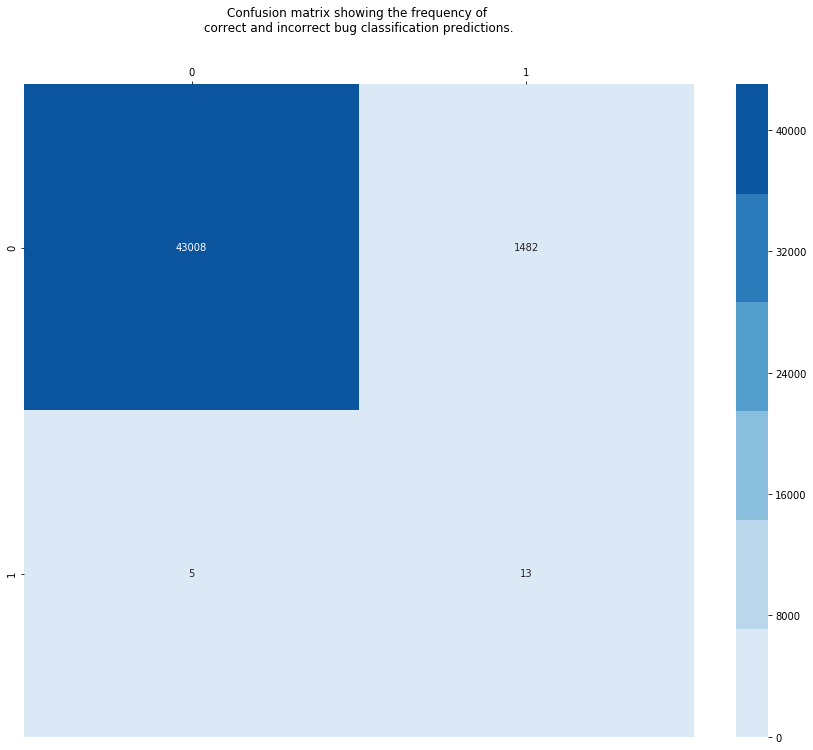

In [246]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(15, 12)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)